<center><img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="30%" /></center>

<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395 Introducción a las redes neuronales artificiales and deep learning 2022-1 </h1>

<H3 align='center'> Ayudantía II: Redes Neuronales Convolucionales </H3>

----

<H3 align='center'> <b>Profesores: Ricardo Ñanculef - Ignacio Loayza </b> </H3>
<H3 align='center'> <b>Ayudantes: Francisco Andrades - Mario Mallea </b> </H3>



<hr style="height:2px;border:none"/>


▶ Video:  Pendiente

# Redes Neuronales Convolucionales

![](https://docs.ecognition.com/Resources/Images/ECogUsr/UG_CNN_scheme.png)


### Librerías y semillas

In [1]:
import pandas as pd # pandas
import numpy as np # numpy
import matplotlib.pyplot as plt # pyplot, graficar
import seaborn as sns # seaborn, graficar mejor. Se ocupa junto a pyplot.

import glob # leer archivos desde directorio
import os # os
import math # math
import h5py # leer archivos .h5 , no es muy relevante, solo es pertinente al caso de estudio.

import sklearn # ML clásico, MUCHAS funciones utiles 
from sklearn.model_selection import train_test_split #divide los datos en train y test

import tensorflow as tf # tensorflow, framework popular para deep learning
from tensorflow import keras # keras, abstracción de alto nivel para construir modelos de DL.
from tensorflow.keras import layers,Model # en layers están todas las capas, Model es la clase modelo
from tensorflow.keras.utils import Sequence # IMPORTANTE, lo veremos en el notebook
from tensorflow.keras.callbacks import EarlyStopping # callbacks: acciones que toma el modelo mientras está entrenando, monitoreando la performance.
                                                     # EarlyStopping: si la 'loss' no mejora en N epochs, detener entrenamiento. 

from tensorflow.keras.models import Sequential # crea un modelo SECUENCIAL, sin skip connections. (una capa siempre consume a la anterior). Fácil pero con poca flexibilidad.
from tensorflow.keras.layers import Dense, Activation #Capa densa
from tensorflow.keras.layers import Conv1D,Conv2D, MaxPooling2D, Flatten # Capas convolucionales
from tensorflow.keras.layers import Dropout, BatchNormalization # Dropout , Batchnormalization
from tensorflow.keras import optimizers #Optimizadores 


from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

## Caso de Estudio 1: CIFAR10 | Básico

Temas:
* Pre-procesamiento
* Comparación Feed Forward vs Convolutional

### Análisis exploratorio de datos (EDA)

170508288/170498071 [==============================] - 6s 0us/step


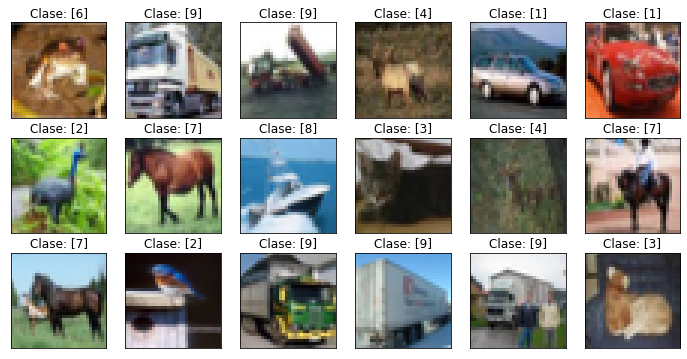


dimensiones...

X_train shape (50000, 32, 32, 3)
X_test shape (10000, 32, 32, 3)


In [2]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data() #cargamos cifar10, ya viene dividido en train y test.


fig = plt.figure(figsize=(12, 6)) #vemos algunas imagenes
for i in range(18):
    plt.subplot(3,6,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Clase: {}".format(y_train[i]))
    plt.xticks([])
    plt.yticks([])

plt.show()

print("\ndimensiones...\n")
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)

 ### Clases

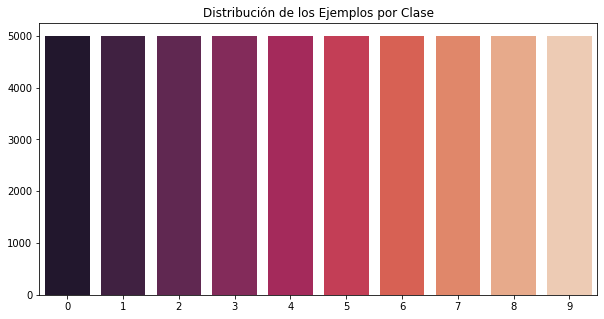

In [3]:
clases, frecuencia = np.unique(y_train, return_counts=True)

fig, ax = plt.subplots(figsize=(10,5),nrows=1)
p = sns.barplot(x=clases, y=frecuencia, palette="rocket",ax=ax)
ax.set_title('Distribución de los Ejemplos por Clase')
plt.show()


#### Clases balanceadas

In [4]:
print('Dimension y_train:', y_train.shape, '; Dimension y_test:', y_test.shape)

Dimension y_train: (50000, 1) ; Dimension y_test: (10000, 1)


### Tenemos que hacer un OneHotEncoding de las clases

Clase 0 -> (1,0,0,0,0,0,0,0,0)\
Clase 1 -> (0,1,0,0,0,0,0,0,0)\
Clase 2 -> (0,0,1,0,0,0,0,0,0)\
...

* Nota: Cuando se define un modelo, hay ciertas *losses* que permiten que las clases estén sin OneHotEncoding, esto simplemente significa que lo hacen por detrás. *sparse_categorical_crossentropy* es un ejemplo, pide que las clases se entreguen como enteros.

¿Como hacemos el OneHotEncoding?

Conozco 3 herramientas, pero recomiendo 1:

* pandas.get_dummies
* keras.utils.to_categorical
* sklearn.preprocessing.OneHotEncoder (Recomiendo)

In [5]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown = 'ignore',sparse=False)
y_train = encoder.fit_transform(y_train.reshape(-1,1))
y_test = encoder.transform(y_test.reshape(-1,1))

print('Dimension y_train:', y_train.shape, '; Dimension y_test:', y_test.shape)

Dimension y_train: (50000, 10) ; Dimension y_test: (10000, 10)


### Comparemos un modelo Feed Forward y un modelo Convolucional.

#### Feed Forward

El modelo Feed Forward sólo puede trabajar con vectores, transformemos cada imagen de dimensión $R^2:(pix_x,pix_y)$ a un vector de dimensión $R^1:(pix_x*pix_y)$

In [6]:
X_train_flatten = X_train.reshape(X_train.shape[0],-1).astype('float32')
X_test_flatten = X_test.reshape(X_test.shape[0],-1).astype('float32')

print("\ndimensiones...\n")
print("X_train shape:", X_train_flatten.shape)
print("X_test shape:", X_test_flatten.shape)


dimensiones...

X_train shape: (50000, 3072)
X_test shape: (10000, 3072)


Nuestros datos ya no son imágenes! ahora tenemos vectores. Existe algún problema con esto?\
...
##### Definamos el modelo Feed Forward

In [7]:
model = Sequential()
model.add(Dense(20, input_shape=(X_train_flatten.shape[1],), activation="relu")) #dim entrada ,
model.add(Dense(20,activation="relu"))
model.add(Dense(10,activation="softmax")) #clases a clasificar, 10 es el numero de clases.
#0.1 , 0.001, 0.0001
opt = tf.keras.optimizers.SGD(learning_rate=0.1) #impacto en velocidad de convergencia y calidad del minimo, SGD: Stochastic Gradient Descent.
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt) # Después de plantear la arquitectura del modelo, hay que compilarlo.

2022-04-17 06:15:22.004519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 06:15:22.084709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 06:15:22.085496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 06:15:22.086618: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                61460     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
Total params: 62,090
Trainable params: 62,090
Non-trainable params: 0
_________________________________________________________________
None


Algunas notas:

* El planteamiento del modelo es un proceso **iterativo**, hay parámetros que tunear, es decir, **probar** distintas configuraciones.
    * Ejemplos de parámetros: Learning Rate , Batch Size, Número de capas, Número de neuronas, ...
    
* Despues de plantear el modelo, hay que **compilarlo**: Esto inicializa los pesos al azar y define la *loss* de entrenamiento, métricas a monitorear y el algoritmo que optimizará la loss (optimizador).
    * Un modelo compilado es capaz de predecir, sólo que tiene pesos al azar y predice cualquier cosa.
* Como actualizamos los pesos? **Entrenando**

In [9]:
model.evaluate(X_test_flatten,y_test) #predice cualquier cosa

2022-04-17 06:15:25.546022: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


313/313 [==============================] - 2s 3ms/step - loss: 328.2194 - accuracy: 0.1024


[328.2193603515625, 0.10239999741315842]

### Entrenamiento

In [10]:
from sklearn.model_selection import train_test_split

X_train_flatten, X_val_flatten, y_train_flatten, y_val_flatten = train_test_split(X_train_flatten, y_train, test_size=0.2, random_state=0,shuffle=True) #straify...
#estandarizacion
X_train_flatten /= 255
X_val_flatten /= 255
X_test_flatten /= 255

In [11]:
history = model.fit(X_train_flatten, y_train_flatten, 
                    batch_size=128, epochs=20, 
                    verbose=1, 
                    validation_data=(X_val_flatten, y_val_flatten))

Epoch 1/20
313/313 [==============================] - 2s 4ms/step - loss: 2.2175 - accuracy: 0.1619 - val_loss: 2.0979 - val_accuracy: 0.1902
Epoch 2/20
313/313 [==============================] - 1s 3ms/step - loss: 2.0804 - accuracy: 0.2094 - val_loss: 2.0500 - val_accuracy: 0.2123
Epoch 3/20
313/313 [==============================] - 1s 4ms/step - loss: 2.0365 - accuracy: 0.2222 - val_loss: 2.1138 - val_accuracy: 0.2034
Epoch 4/20
313/313 [==============================] - 1s 3ms/step - loss: 1.9923 - accuracy: 0.2553 - val_loss: 1.9323 - val_accuracy: 0.2778
Epoch 5/20
313/313 [==============================] - 1s 3ms/step - loss: 1.9423 - accuracy: 0.2863 - val_loss: 1.9950 - val_accuracy: 0.2549
Epoch 6/20
313/313 [==============================] - 1s 4ms/step - loss: 1.9085 - accuracy: 0.3024 - val_loss: 1.8812 - val_accuracy: 0.3158
Epoch 7/20
313/313 [==============================] - 1s 4ms/step - loss: 1.8773 - accuracy: 0.3137 - val_loss: 1.8670 - val_accuracy: 0.3189
Epoch 

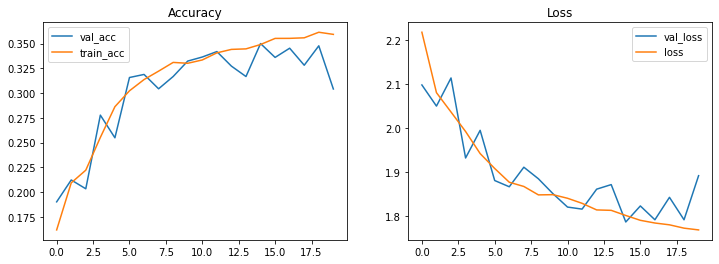

In [12]:
fig, axis = plt.subplots(1, 2, figsize=(12,4))
axis[0].plot(history.history['val_accuracy'], label='val_acc')
axis[0].plot(history.history['accuracy'], label='train_acc')
axis[0].set_title("Accuracy")
axis[0].legend()
axis[1].plot(history.history['val_loss'], label='val_loss')
axis[1].plot(history.history['loss'], label='loss')
axis[1].set_title("Loss")
axis[1].legend()
plt.show()

313/313 [==============================] - 1s 2ms/step - loss: 1.9037 - accuracy: 0.3020
Evaluation: [1.9036720991134644, 0.3019999861717224]

Confusion Matrix



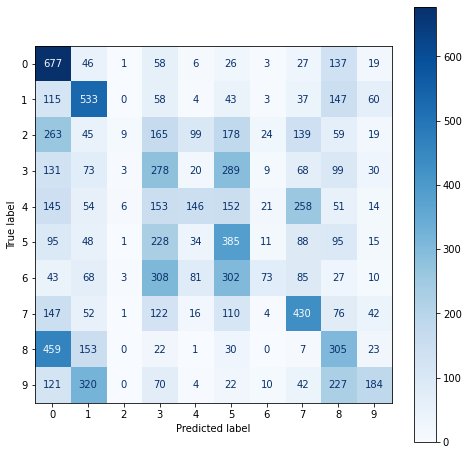


Classification Report

              precision    recall  f1-score   support

           0       0.31      0.68      0.42      1000
           1       0.38      0.53      0.45      1000
           2       0.38      0.01      0.02      1000
           3       0.19      0.28      0.23      1000
           4       0.36      0.15      0.21      1000
           5       0.25      0.39      0.30      1000
           6       0.46      0.07      0.13      1000
           7       0.36      0.43      0.39      1000
           8       0.25      0.30      0.27      1000
           9       0.44      0.18      0.26      1000

    accuracy                           0.30     10000
   macro avg       0.34      0.30      0.27     10000
weighted avg       0.34      0.30      0.27     10000



In [13]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

Y_pred = model.predict(X_test_flatten)
print("Evaluation:", model.evaluate(X_test_flatten, y_test))

# hay deshacer el one hot
y_pred_crisp = np.argmax(Y_pred, axis=1)
y_test_crisp = np.argmax(y_test, axis=1)

target_names = [str(i) for i in range(10)]

print("\nConfusion Matrix\n")
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_test_crisp, y_pred_crisp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.show()

print("\nClassification Report\n")

print(classification_report(y_test_crisp, y_pred_crisp, target_names=target_names))


### Red Convolucional

Aquí podemos trabajar con imágenes como input y aprovechar la información espacial.

In [14]:
X_train_img , X_val_img , y_train_img , y_val_img = train_test_split(X_train, y_train, test_size=0.2, random_state=0,shuffle=True)


X_train_img = X_train_img.astype('float32') / 255
X_val_img = X_val_img.astype('float32') / 255
X_test_img = X_test.astype('float32') / 255
print(X_train_img.shape)

(40000, 32, 32, 3)


#### Definamos el modelo Convolucional

In [15]:
def define_model():
    model = Sequential()
    
    # Un patrón comun es un stack de 2 capas convolucionales seguidas de una capa de maxpooling
    model.add(Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(32, 32,3))) # 32 es el numero de canales, (3,3) es el tamaño del filtro
    model.add(Conv2D(32, (3, 3), activation='relu',padding='same')) # padding mantiene el tamaño apropiado rellenando con 0's
    model.add(MaxPooling2D((2, 2), padding='same')) # pooling es necesario para controlar la dimensionalidad. Con tamaño (2,2) junta 4 pixeles en 1
                                                    # hay otros tipos de pooling, MaxPooling toma el pixel con el valor mas grande entre los 4
    model.add(Conv2D(16, (3, 3), activation='relu',padding='same'))
    model.add(Conv2D(16, (3, 3), activation='relu',padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    
    model.add(Flatten()) # la matriz resultante de las capas convolucionales no es compatible con una capa densa. La 'aplanamos' primero.
    model.add(Dense(20, activation='relu')) # una pequeña capa para procesar un poco
    model.add(Dense(10, activation='softmax')) # capa que clasifica
    # compile model
    opt = optimizers.SGD()
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
model = define_model()

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        4624      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)             

In [17]:
history = model.fit(X_train_img, y_train_img, 
                    batch_size=128, epochs=20, 
                    verbose=1, 
                    validation_data=(X_val_img, y_val_img))

Epoch 1/20


2022-04-17 06:16:02.910256: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


313/313 [==============================] - 8s 8ms/step - loss: 2.2762 - accuracy: 0.1230 - val_loss: 2.2067 - val_accuracy: 0.1785
Epoch 2/20
313/313 [==============================] - 2s 7ms/step - loss: 2.1118 - accuracy: 0.2198 - val_loss: 1.9955 - val_accuracy: 0.2830
Epoch 3/20
313/313 [==============================] - 2s 6ms/step - loss: 1.9740 - accuracy: 0.2961 - val_loss: 1.8926 - val_accuracy: 0.3194
Epoch 4/20
313/313 [==============================] - 2s 6ms/step - loss: 1.8867 - accuracy: 0.3295 - val_loss: 2.0102 - val_accuracy: 0.2991
Epoch 5/20
313/313 [==============================] - 2s 6ms/step - loss: 1.8188 - accuracy: 0.3510 - val_loss: 1.8751 - val_accuracy: 0.3264
Epoch 6/20
313/313 [==============================] - 2s 6ms/step - loss: 1.7566 - accuracy: 0.3755 - val_loss: 1.7009 - val_accuracy: 0.3822
Epoch 7/20
313/313 [==============================] - 2s 7ms/step - loss: 1.6806 - accuracy: 0.3956 - val_loss: 1.6611 - val_accuracy: 0.3978
Epoch 8/20
313/31

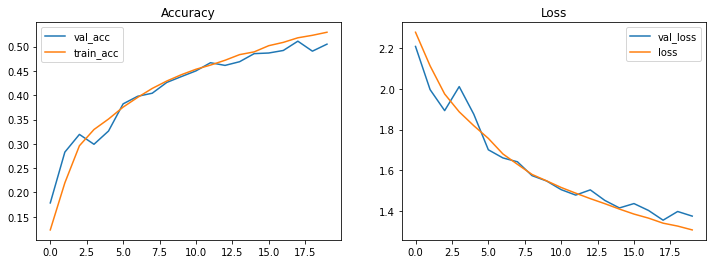

In [18]:
fig, axis = plt.subplots(1, 2, figsize=(12,4))
axis[0].plot(history.history['val_accuracy'], label='val_acc')
axis[0].plot(history.history['accuracy'], label='train_acc')
axis[0].set_title("Accuracy")
axis[0].legend()
axis[1].plot(history.history['val_loss'], label='val_loss')
axis[1].plot(history.history['loss'], label='loss')
axis[1].set_title("Loss")
axis[1].legend()
plt.show()

313/313 [==============================] - 1s 3ms/step - loss: 1.3674 - accuracy: 0.5087
Evaluation: [1.3673949241638184, 0.5087000131607056]

Confusion Matrix



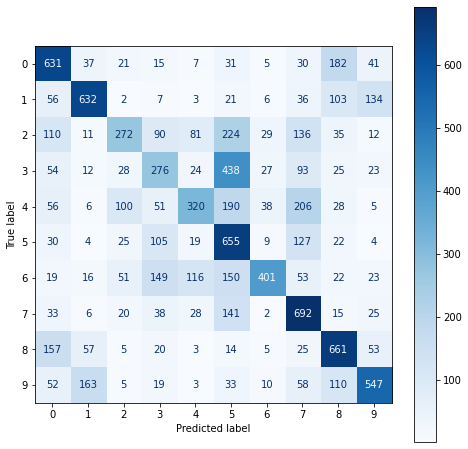


Classification Report

              precision    recall  f1-score   support

           0       0.53      0.63      0.57      1000
           1       0.67      0.63      0.65      1000
           2       0.51      0.27      0.36      1000
           3       0.36      0.28      0.31      1000
           4       0.53      0.32      0.40      1000
           5       0.35      0.66      0.45      1000
           6       0.75      0.40      0.52      1000
           7       0.48      0.69      0.56      1000
           8       0.55      0.66      0.60      1000
           9       0.63      0.55      0.59      1000

    accuracy                           0.51     10000
   macro avg       0.54      0.51      0.50     10000
weighted avg       0.54      0.51      0.50     10000



In [19]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

Y_pred = model.predict(X_test_img)
print("Evaluation:", model.evaluate(X_test_img, y_test))

# hay deshacer el one hot
y_pred_crisp = np.argmax(Y_pred, axis=1)
y_test_crisp = np.argmax(y_test, axis=1)

target_names = [str(i) for i in range(10)]

print("\nConfusion Matrix\n")
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_test_crisp, y_pred_crisp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.show()

print("\nClassification Report\n")

print(classification_report(y_test_crisp, y_pred_crisp, target_names=target_names))



#### Modelo Convolucional logró mejor performance aún teniendo la mitad de parámetros entrenables!

## Caso de estudio 2: CIFAR10 | Intermedio

**Temas** 
* ImageDataGenerator (Keras)
* Modelos PreEntrenados


### ImageDataGenerator (tf.keras.preprocessing.image.ImageDataGenerator)

En el caso de estudio 1, cargamos todas las imágenes del dataset de inmediato. Qué pasa cuando el dataset es muy pesado? Este escenario es común y, aunque no fuera su caso, siempre debemos cuidar los recursos disponibles.

Tanto Tensorflow/keras como Pytorch tienen herramientas para lidiar con este problema y su uso es recomendado.

Estas herramientas se aprovechan de que el modelo entrena en batchs, por lo que sólo cargan las imágenes cuando van a ser usadas (32 imágenes a la vez, si es que el batch_size es de 32). 

La herramienta que dispone keras para tratar con imágenes es ImageDataGenerator, que recibe un directorio como argumento (donde están guardadas todas las imágenes en disco) y las va haciendo fluir al modelo de a poco. Además, puede hacerle transformaciones a las imágenes para augmentar los datos (rotaciones, traslaciones, brillo, ... ; mutaciones en general, nosotros las definimos).


**Ventajas**
* Escalable en RAM
* Augmenta datos de forma muy fácil

**Desventaja**
* Overhead en tiempo

**Carguemos CIFAR10 con ImageDataGenerator y entrenemos el mismo modelo**

Para esto, tenemos 2 directorios con las imágenes (Antes las cargábamos directamente con Keras).

Cada uno de los directorios contiene las imágenes de CIFAR10, la diferencia es cómo están estructurados. Vamos a ver como ocupar ImageDataGenerator para los 2 formatos.

#### Directorio cifar10-raw-images

* cifar10-raw-images/
    * images/
        * test/
            * clase_0/
                * imagenes
            * clase_1/
                * imagenes
            ...
        * train/
            * clase_0/
                * imagenes
            * clase_1/
                * imagenes
            ...
            
El directorio representa las clases de cada imagen en la carpeta que la contiene. ImageDataGenerator es compatible con esta estructura.

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
path = '../input/cifar10-raw-images/images/'

train_datagen = ImageDataGenerator( #instanciamos el generator para entrenamiento
    rescale=1./255, #le decimos que tiene que escalar las imagenes
    validation_split=0.2) # le decimos que queremos un conjunto de validacion
    # ver la documentacion para más mutaciones

test_datagen = ImageDataGenerator(rescale=1./255) #instanciamos el generator para test

# el metodo flow_from_directory espera un directorio estructurado de la forma que tenemos, se encarga de codificar las clases de acuerdo a las carpetas

train_generator = train_datagen.flow_from_directory(directory=path+'train',
                                                    target_size=(32,32), #target final de las imágenes, si definimos uno distinto al que vienen las escala
                                                    batch_size = 128,
                                                    seed = 0,
                                                    subset = 'training' #conjunto de train
                                                   )

val_generator = train_datagen.flow_from_directory(directory=path+'train',
                                                    target_size=(32,32),
                                                    batch_size = 128,
                                                    seed = 0,
                                                    subset = 'validation' # conjunto de validation
                                                   )
test_generator = test_datagen.flow_from_directory(directory=path+'test',
                                                 target_size=(32,32),
                                                 batch_size = 128,
                                                 seed = 0
                                                )

Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [21]:
model = define_model() #definimos modelo convolucion
history = model.fit(train_generator,  #el metodo .fit` de keras es compatible con generators
                    batch_size=128, # batch_size igual a generators
                    epochs=20, 
                    verbose=1, 
                    validation_data=val_generator)

Epoch 1/20
313/313 [==============================] - 194s 619ms/step - loss: 2.3005 - accuracy: 0.1170 - val_loss: 2.2985 - val_accuracy: 0.1302
Epoch 2/20
313/313 [==============================] - 38s 120ms/step - loss: 2.2925 - accuracy: 0.1522 - val_loss: 2.2869 - val_accuracy: 0.1562
Epoch 3/20
313/313 [==============================] - 36s 115ms/step - loss: 2.2612 - accuracy: 0.1918 - val_loss: 2.2326 - val_accuracy: 0.2090
Epoch 4/20
313/313 [==============================] - 36s 116ms/step - loss: 2.1272 - accuracy: 0.2493 - val_loss: 2.0471 - val_accuracy: 0.2633
Epoch 5/20
313/313 [==============================] - 38s 123ms/step - loss: 1.9390 - accuracy: 0.3109 - val_loss: 2.0456 - val_accuracy: 0.2759
Epoch 6/20
313/313 [==============================] - 38s 121ms/step - loss: 1.8053 - accuracy: 0.3578 - val_loss: 1.9436 - val_accuracy: 0.2987
Epoch 7/20
313/313 [==============================] - 41s 132ms/step - loss: 1.7053 - accuracy: 0.3921 - val_loss: 1.7322 - val_a

In [22]:
model.evaluate(test_generator)

79/79 [==============================] - 35s 446ms/step - loss: 1.2988 - accuracy: 0.5371


[1.2987737655639648, 0.5371000170707703]

#### Vemos que es más lento, pero que ocupa poca RAM.
Para una posible solución al overhead, revisar el anexo.

#### Directorio cifar10

* cifar
    * test
        * imagenes
    * train
        * imagenes
    * labels.txt
    
Aquí no tenemos las clases codificadas en carpetas, nos las entregan en el nombre de las imágenes. Podemos ocupar ImageDataGenerator para este tipo de formato, pero hay que hacer algunas cosas.

In [23]:
# Primero leemos los nombres de las imagenes del directorio
path = '../input/cifar10/cifar/'
files_train = glob.glob(path+'train/*.png')
files_test = glob.glob(path+'test/*.png')
print(len(files_train),len(files_test))
print(files_train[0])

50000 10000
../input/cifar10/cifar/train/29606_airplane.png


In [24]:
files_train = [file.split('/')[-1] for file in files_train]
files_test = [file.split('/')[-1] for file in files_test]
files_train[0]

'29606_airplane.png'

In [25]:
#obtengamos las clases de todas las imagenes a partir de su nombre
clases_train = [file.split('_')[-1][:-4] for file in files_train]
clases_test = [file.split('_')[-1][:-4] for file in files_test]

In [26]:
# planteamos un df con la ubicacion de cada imagen y su clase
df_train = pd.DataFrame(np.array([files_train,clases_train]).T,columns=['image_dir','class'])
df_test = pd.DataFrame(np.array([files_test,clases_test]).T,columns=['image_dir','class'])

df_train.head()

,image_dir,class
0,29606_airplane.png,airplane
1,7498_cat.png,cat
2,46129_horse.png,horse
3,4994_cat.png,cat
4,32578_ship.png,ship


In [27]:
train_generator = train_datagen.flow_from_dataframe(dataframe = df_train,
                                                    directory = '../input/cifar10/cifar/train/', #directorio base
                                                    x_col = 'image_dir', #nombres son relativos al directorio base
                                                    y_col = 'class',
                                                    target_size=(32,32),
                                                    batch_size = 128,
                                                    seed = 0,
                                                    subset = 'training'
                                                   )

val_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                  directory = '../input/cifar10/cifar/train/',
                                                  x_col = 'image_dir',
                                                  y_col = 'class',
                                                  target_size=(32,32),
                                                  batch_size = 128,
                                                  seed = 0,
                                                  subset = 'validation'
                                                   )
test_generator = test_datagen.flow_from_dataframe(dataframe = df_test,
                                                  directory = '../input/cifar10/cifar/test/', 
                                                  x_col = 'image_dir', 
                                                  y_col = 'class',
                                                  target_size=(32,32),
                                                  batch_size = 128,
                                                  seed = 0
                                                )

Found 40000 validated image filenames belonging to 10 classes.
Found 10000 validated image filenames belonging to 10 classes.
Found 10000 validated image filenames belonging to 10 classes.


In [28]:
model = define_model() #definimos modelo convolucion
history = model.fit(train_generator,  
                    batch_size=128,
                    epochs=5, 
                    verbose=1, 
                    validation_data=val_generator)

Epoch 1/5
313/313 [==============================] - 186s 594ms/step - loss: 2.2801 - accuracy: 0.1413 - val_loss: 2.2424 - val_accuracy: 0.1676
Epoch 2/5
313/313 [==============================] - 36s 114ms/step - loss: 2.1880 - accuracy: 0.1913 - val_loss: 2.1232 - val_accuracy: 0.2231
Epoch 3/5
313/313 [==============================] - 34s 109ms/step - loss: 2.0348 - accuracy: 0.2625 - val_loss: 1.9458 - val_accuracy: 0.3032
Epoch 4/5
313/313 [==============================] - 36s 114ms/step - loss: 1.8500 - accuracy: 0.3438 - val_loss: 1.7738 - val_accuracy: 0.3689
Epoch 5/5
313/313 [==============================] - 35s 113ms/step - loss: 1.7361 - accuracy: 0.3790 - val_loss: 1.7468 - val_accuracy: 0.3744


In [29]:
model.evaluate(test_generator)

79/79 [==============================] - 37s 471ms/step - loss: 1.7230 - accuracy: 0.3796


[1.7230197191238403, 0.37959998846054077]

##### flow_from_dataframe se puede usar con cualquier formato de directorio que permita formar el dataframe con las ubicaciones de las imágenes y su clase, es bastante universal.

### Modelos PreEntrenados

Existen modelos que ya fueron entrenados en datasets gigantes y que son capaces de generalizar en problemas parecidos.
Para el caso de imágenes, los más conocidos son los modelos entrenados en el dataset ImageNet.
Podemos ajustar estos modelos a nuestro dataset para mejorar el desempeño.

In [30]:
from tensorflow.keras.applications import DenseNet201 #hay otros modelos
model = DenseNet201(include_top=False, #no incluimos la capa de clasificación, vamos a poner la nuestra con el numero de clases apropiado
                   weights='imagenet', #modelo entrenado en imagenet
                   input_shape=(32, 32, 3), #imput de nuestras imagenes
                   pooling='max', #pooling de la ultima capa convolucional
                   classes=10) #nuestro numero de clases
model.summary()

74850304/74836368 [==============================] - 1s 0us/step
Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
_______________________

**Podemos ver que es un modelo gigante, con una arquitectura especializada**

**Intuición sobre modelos PreEntrenados:**

Las capas más superficiales del modelo (primeras capas) aprendieron pesos que distinguen propiedades generales importantes para muchas imágenes (propiedades transversales a varios problemas).

Las capas más profundas, en cambio, aprendieron pesos especializados al dataset con el que fueron entrenadas. Distinguen propiedades específicas al problema que **no son transversales**

Podemos *congelar* las capas superficiales, es decir, que en el proceso de entrenamiento **no se actualicen sus pesos**. Así sólo entrenaremos las capas profundas. Este proceso se conoce como Fine-Tuning y busca ajustar el modelo PreEntrenado a nuestro dataset.


##### Probemos congelando todas las capas y agregando una capa densa para clasificar nuestras clases

In [31]:
for layer in model.layers:
    layer.trainable = False #congelamos cada capa
    
# aqui voy a plantear el modelo usando la api funcional de keras, es distinto al modelo sequencial.
output = model.layers[-1].output #output de densenet
output = layers.Flatten()(output) #aplanamos el output de la cnn para pasarselo a la capa densa, igual que en nuestro modelo
output = Dense(10,activation='softmax')(output) #nuestra capa consume el output de densenet aplanado y clasifica

model2 = Model(inputs=model.input, outputs=output) #le indicamos al modelo que reciba el input de densenet como input, pero que el output sea el de nuestra capa
opt = optimizers.SGD()
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
history = model2.fit(train_generator,  
                    batch_size=128, 
                    epochs=20, 
                    verbose=1, 
                    validation_data=val_generator)

Epoch 1/20
313/313 [==============================] - 57s 150ms/step - loss: 1.6872 - accuracy: 0.4202 - val_loss: 1.4655 - val_accuracy: 0.5015
Epoch 2/20
313/313 [==============================] - 43s 136ms/step - loss: 1.3941 - accuracy: 0.5271 - val_loss: 1.3456 - val_accuracy: 0.5452
Epoch 3/20
313/313 [==============================] - 41s 132ms/step - loss: 1.3065 - accuracy: 0.5534 - val_loss: 1.2894 - val_accuracy: 0.5614
Epoch 4/20
313/313 [==============================] - 41s 131ms/step - loss: 1.2563 - accuracy: 0.5731 - val_loss: 1.2562 - val_accuracy: 0.5716
Epoch 5/20
313/313 [==============================] - 41s 129ms/step - loss: 1.2215 - accuracy: 0.5834 - val_loss: 1.2296 - val_accuracy: 0.5799
Epoch 6/20
313/313 [==============================] - 41s 129ms/step - loss: 1.1960 - accuracy: 0.5925 - val_loss: 1.2092 - val_accuracy: 0.5857
Epoch 7/20
313/313 [==============================] - 41s 132ms/step - loss: 1.1762 - accuracy: 0.5978 - val_loss: 1.1988 - val_ac

In [33]:
model2.evaluate(test_generator)

79/79 [==============================] - 8s 101ms/step - loss: 1.1296 - accuracy: 0.6149


[1.1295984983444214, 0.6148999929428101]

##### Se pueden dejar las N últimas capas sin congelar para intentar mejorar, N es un parámetro a tunear!
Consejo: Cuidado con elegir N de forma arbitraria. En DenseNet, por ejemplo, la arquitectura esta compuesta por bloques (stacks de capas), quizás tenga más sentido descongelar N bloques y no N capas.

### Caso de Estudio 2: Anexo

ImageDataGenerator es una instancia específica de la clase Sequence. Podemos definir nuestra propia clase custom que hereda de Sequence para hacer fluir los datos como nosotros queramos, hay total libertad.

ImageDataGenerator hace varias cosas que no necesitamos para nuestro problema, hagamos una clase custom que haga solo lo necesario a ver si resulta más rápida. 

#### Class Sequence (Keras)

In [34]:
# El método más importante que implementar es __getitem__()
# Por cada batch que el modelo quiere consumir, llama este método del generator. Debería retornar los datos y las labels correspondientes al batch.


class Custom_Sequence(Sequence):
    def __init__(self, x_set, y_set, batch_size,base_dir):
        # en el init definimos los parámetros que van a ser importantes para nuestra clase
        # x_set va a ser una lista con la ubicación de las imágenes
        # y_set van a ser las labels
        # batch_size va a ser el tamaño de batch que vamos a usar (como siempre)
        #base_dir: directorio base para leer las imagenes
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.base_dir = base_dir

    def __len__(self): #importante para definir el numero de steps para completar un epoch
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx): # el modelo llama el metodo con el argumento idx cambiando, keras se encarga de eso (aumenta en 1)
        
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size] #tomamos un batch de x
        
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size] # tomamos el batch de las labels
        
        return np.array([plt.imread(self.base_dir+file_name) #plt.imread devuelve las imagenes png ya escaladas entre 0 y 1
                         for file_name in batch_x]), np.array(batch_y) #leemos las imagenes y retornamos la tupla (array(imagenes),labels)
    
    def on_epoch_end(self):
        #Aqui podemos hacer cosas cada vez que un epoch termine
        pass

In [35]:
df_train , df_val = train_test_split(df_train,test_size = 0.2,shuffle = True,random_state = 0)
df_train.head()

,image_dir,class
20330,14536_cat.png,cat
17532,19878_airplane.png,airplane
45819,46635_dog.png,dog
34807,49158_truck.png,truck
31888,27500_deer.png,deer


In [36]:
X_train , y_train = df_train['image_dir'].values , df_train['class'].values
X_val , y_val = df_val['image_dir'].values , df_val['class'].values
X_test , y_test = df_test['image_dir'].values , df_test['class'].values

# onehotencoding de las clases
encoder = OneHotEncoder(handle_unknown='ignore',sparse = False)
y_train = encoder.fit_transform(y_train.reshape(-1,1))
y_val = encoder.transform(y_val.reshape(-1,1))
y_test = encoder.transform(y_test.reshape(-1,1))

In [37]:
train_generator = Custom_Sequence(X_train,y_train,128,base_dir = '../input/cifar10/cifar/train/')    
val_generator = Custom_Sequence(X_val,y_val,128,base_dir='../input/cifar10/cifar/train/')
test_generator = Custom_Sequence(X_test,y_test,128,base_dir='../input/cifar10/cifar/test/')

In [38]:
model = define_model() #definimos modelo convolucion
STEP_SIZE_TRAIN=train_generator.__len__()
STEP_SIZE_VALID=val_generator.__len__()
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    batch_size=128,
                    epochs=5, 
                    verbose=1, 
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID
                   )

Epoch 1/5
313/313 [==============================] - 36s 114ms/step - loss: 2.2928 - accuracy: 0.1231 - val_loss: 2.2799 - val_accuracy: 0.1513
Epoch 2/5
313/313 [==============================] - 36s 116ms/step - loss: 2.2287 - accuracy: 0.1700 - val_loss: 2.1544 - val_accuracy: 0.2077
Epoch 3/5
313/313 [==============================] - 36s 114ms/step - loss: 2.0732 - accuracy: 0.2496 - val_loss: 2.0341 - val_accuracy: 0.2751
Epoch 4/5
313/313 [==============================] - 37s 120ms/step - loss: 1.9624 - accuracy: 0.2939 - val_loss: 1.9482 - val_accuracy: 0.2912
Epoch 5/5
313/313 [==============================] - 36s 114ms/step - loss: 1.8653 - accuracy: 0.3335 - val_loss: 1.8494 - val_accuracy: 0.3380


##### Es más rápido que ImageDataGenerator.

##### Class Sequence es una herramienta muy útil, puedes hacer fluir cualquier tipo de datos, audios por ejemplo. Hay total libertad.

In [39]:
model.evaluate(test_generator)

79/79 [==============================] - 7s 86ms/step - loss: 1.8279 - accuracy: 0.3445


[1.8278714418411255, 0.34450000524520874]

## Caso de Estudio 3: Landslide4Sense (Competencia Vigente) | Avanzado

![](https://raw.githubusercontent.com/iarai/Landslide4Sense-2022/main/image/Competition_figure.png)

[Link de la competencia](https://www.iarai.ac.at/landslide4sense/)

Landslide4Sense es una competencia gratis y abierta hosteada por el Institute of Advanced Research on Artificial Intelligence (IARAI).

Comenzó el 01 de abril y la primera fase dura unos 2 meses.

La idea es detectar *landslides* en imágenes satelitales. El objetivo es segmentar los landslides encontrados en cada imagen, se puede ver como un problema de clasificación de pixeles o como un problema de generación de máscaras binarias.

Descripción en la competencia:

*Each image patch is a composite of 14 bands that include:*

*Multispectral data from Sentinel-2: B1, B2, B3, B4, B5, B6, B7, B8, B9, B10, B11, B12.*

*Slope data from ALOS PALSAR: B13.*

*Digital elevation model (DEM) from ALOS PALSAR: B14.*

*All bands in the competition dataset are resized to the resolution of ~10m per pixel. The image patches have the size of 128 x 128 pixels and are labeled pixel-wise.*


![](https://raw.githubusercontent.com/iarai/Landslide4Sense-2022/main/image/Data_figure.png)

Hagamos una propuesta base usando redes convolucionales.

#### Leemos las imágenes

In [40]:
path = '../input/lanslide4sense/'
imgs = sorted(glob.glob(path+"TrainData/TrainData/img/*.h5"))
masks = sorted(glob.glob(path+"TrainData/TrainData/mask/*.h5"))

train_imgs, test_imgs, train_masks, test_masks = train_test_split(imgs,masks,test_size=0.2,shuffle=True,random_state = 0)

print(str(len(train_imgs))+" Imagenes en train ;",str(len(test_imgs))+" Imagenes en test")

3039 Imagenes en train ; 760 Imagenes en test


#### Veamos algunas imágenes con sus máscaras

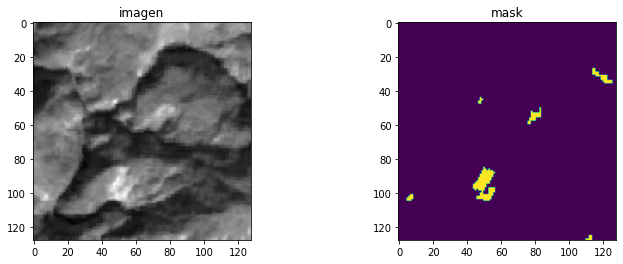

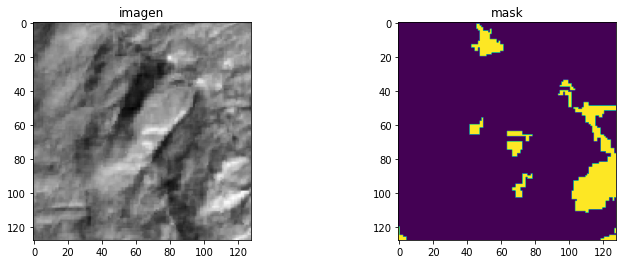

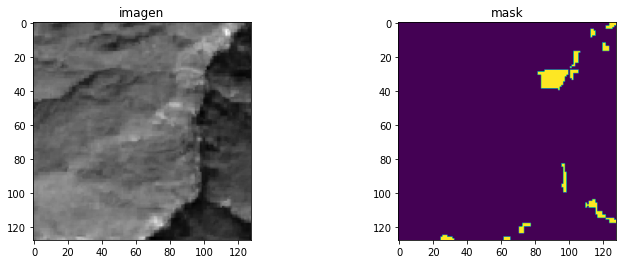

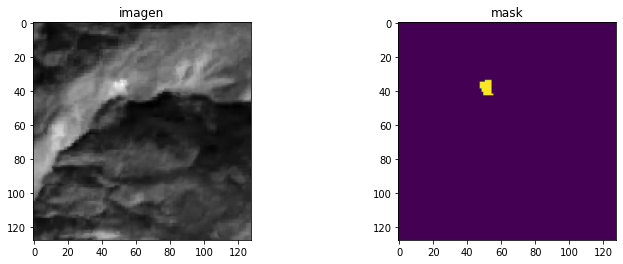

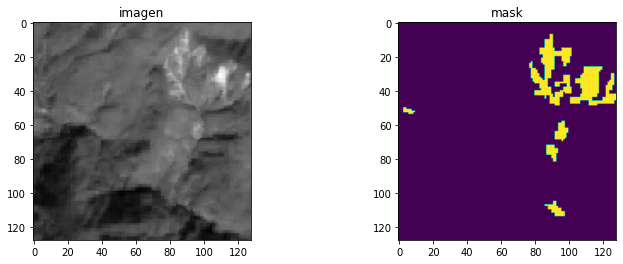

In [41]:
images_to_see = train_imgs[:5]
masks_to_see = train_masks[:5]

for image,mask in zip(images_to_see,masks_to_see):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    with h5py.File(image, "r") as f_img , h5py.File(mask, "r") as f_mask:
        a_group_key = list(f_img.keys())[0]
        img = np.array(f_img[a_group_key])

        gray_img = img.mean(axis=-1)
        
        b_group_key = list(f_mask.keys())[0]
        mask = np.array(f_mask[b_group_key])
        
        
        axs[0].imshow(gray_img,cmap='gray')
        axs[0].set_title("imagen")
        axs[1].imshow(mask)
        axs[1].set_title("mask")
        plt.show()

#### Veamos los 14 canales de una imagen

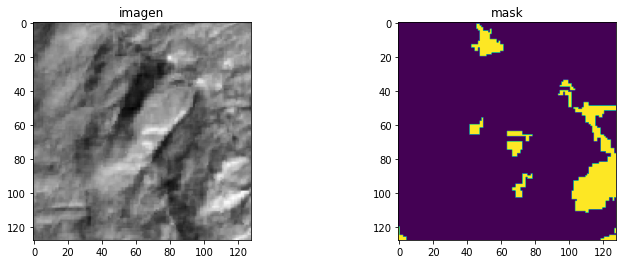

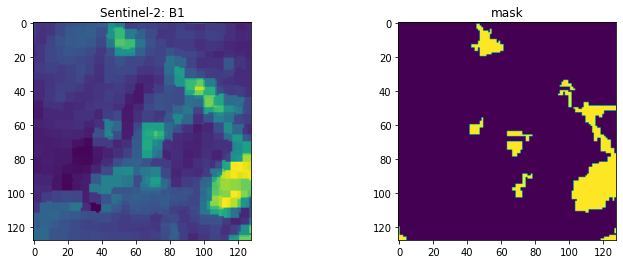

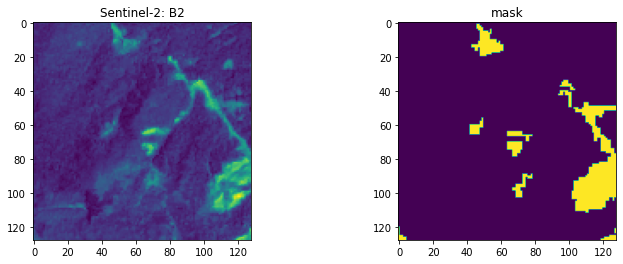

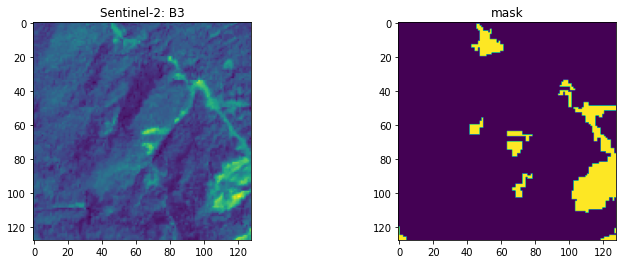

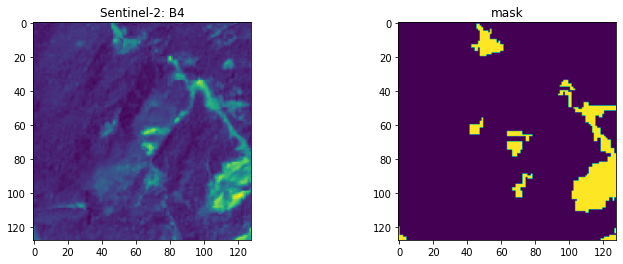

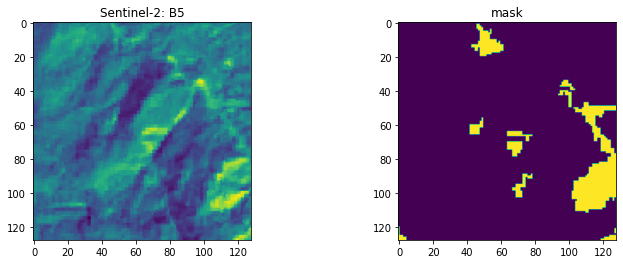

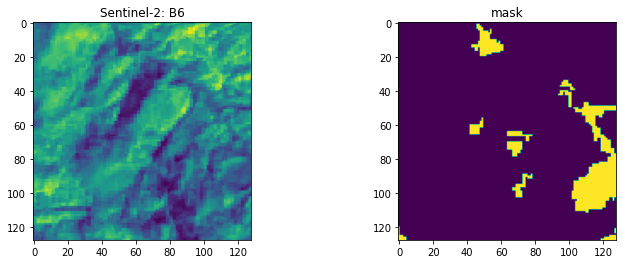

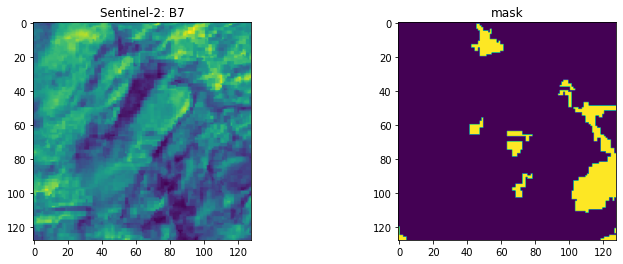

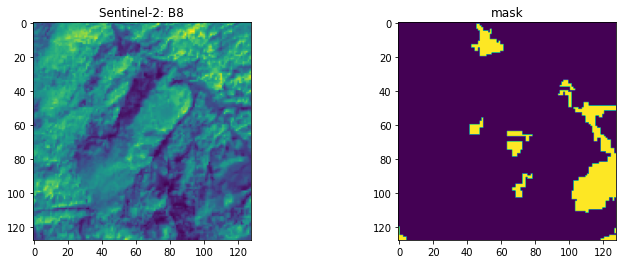

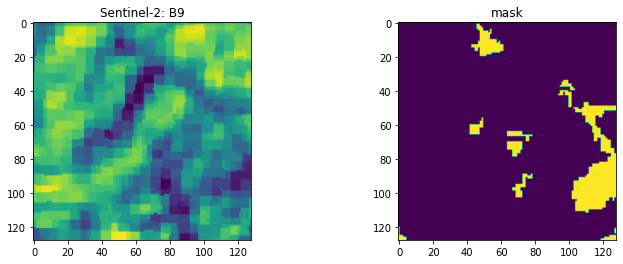

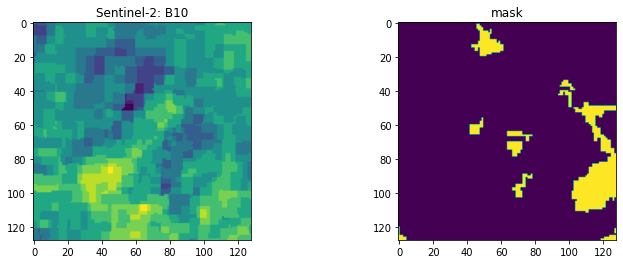

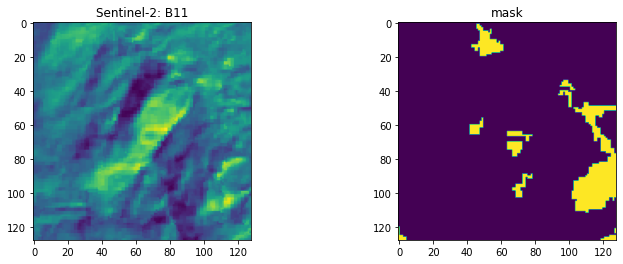

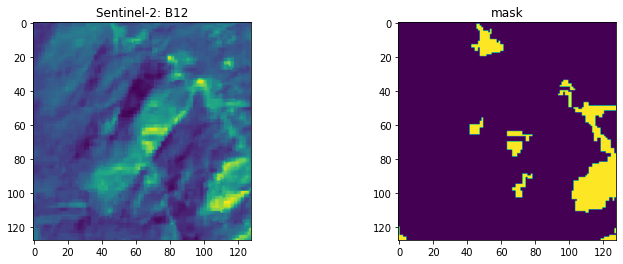

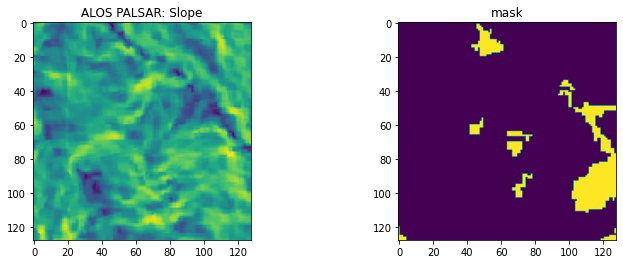

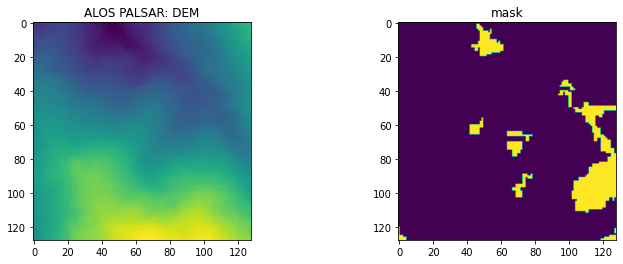

In [42]:
canales = ['Sentinel-2: B1','Sentinel-2: B2',
           'Sentinel-2: B3','Sentinel-2: B4',
           'Sentinel-2: B5','Sentinel-2: B6',
           'Sentinel-2: B7','Sentinel-2: B8',
           'Sentinel-2: B9','Sentinel-2: B10',
           'Sentinel-2: B11','Sentinel-2: B12',
           'ALOS PALSAR: Slope','ALOS PALSAR: DEM'
          ]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
with h5py.File(images_to_see[1], "r") as f_img , h5py.File(masks_to_see[1], "r") as f_mask:
        a_group_key = list(f_img.keys())[0]
        img = np.array(f_img[a_group_key])
        
        
        b_group_key = list(f_mask.keys())[0]
        mask = np.array(f_mask[b_group_key])
        
        axs[0].imshow(img.mean(axis=-1),cmap='gray')
        axs[0].set_title("imagen")
        axs[1].imshow(mask)
        axs[1].set_title("mask")
        plt.show()
        for cont in range(14):
            fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
            axs[0].imshow(img[:,:,cont])
            axs[0].set_title(canales[cont])
            axs[1].imshow(mask)
            axs[1].set_title("mask")
            plt.show()

#### Definamos el generator que carga las imágenes (están en .h5)

In [43]:
class Custom_Sequence_Landslide(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
                self.batch_size]
        
        images = []
        masks = []
        for cont, image in enumerate(batch_x):
            with h5py.File(image, "r") as f_img , h5py.File(batch_y[cont], "r") as f_mask:
                a_group_key = list(f_img.keys())[0]
                img = np.array(f_img[a_group_key]) 

                b_group_key = list(f_mask.keys())[0]
                mask = np.array(f_mask[b_group_key])

                images.append(img)
                masks.append(mask)
        images = np.array(images)
        masks = np.array(masks)

        return images,masks

#### Definamos un modelo convolucional

* Importante: Nótese que el modelo recibe como input una imagen de dimensiones (128,128,14) y genera como output otra imagen
* La imagen que genera es de dimensiones (128,128,1) y corresponde a la máscara binaria predicha para el input.
* El modelo se entrena con BinaryCrossEntropy, ya que se entiende como un problema de clasificación para cada pixel de la máscara (0 o 1).
* Spoiler: Si decidiéramos que el output sea la misma imagen que entró, tendríamos un autoencoder.

In [44]:
def define_model_landslide(loss):
    #Las capas de MaxPooling y UpSampling se encargan de que la dimensión final sea de (128*128)
    
    input_img = keras.Input(shape=(128, 128, 14))
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
    encoded = layers.BatchNormalization()(encoded)
    

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) #máscara tiene 1 canal
    model = keras.Model(input_img, decoded)
    model.compile(optimizer='Nadam', loss=loss,metrics = 'accuracy')
    return model

In [45]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,
                           restore_best_weights = True) #si la val_loss no mejora en 5 epochs, detenemos el entrenamiento y nos quedamos con los pesos del mejor epoch
callbacks = [early_stop]

batch_size = 32
train_generator = Custom_Sequence_Landslide(train_imgs,train_masks,batch_size)
val_generator = Custom_Sequence_Landslide(test_imgs,test_masks,batch_size)
model_landslide = define_model_landslide('binary_crossentropy')
STEP_SIZE_TRAIN=train_generator.__len__()
STEP_SIZE_VALID=val_generator.__len__()
history = model_landslide.fit(train_generator,
                          steps_per_epoch=STEP_SIZE_TRAIN,
                          validation_data=val_generator,
                          validation_steps=STEP_SIZE_VALID,
                          epochs = 20,
                          batch_size = batch_size,
                          callbacks = callbacks,
                          verbose = 1)

Epoch 1/20
95/95 [==============================] - 166s 2s/step - loss: 0.4592 - accuracy: 0.8525 - val_loss: 1.0839 - val_accuracy: 0.8940
Epoch 2/20
95/95 [==============================] - 109s 1s/step - loss: 0.0875 - accuracy: 0.9821 - val_loss: 0.0544 - val_accuracy: 0.9829
Epoch 3/20
95/95 [==============================] - 106s 1s/step - loss: 0.0483 - accuracy: 0.9840 - val_loss: 0.0452 - val_accuracy: 0.9839
Epoch 4/20
95/95 [==============================] - 102s 1s/step - loss: 0.0443 - accuracy: 0.9841 - val_loss: 0.0415 - val_accuracy: 0.9841
Epoch 5/20
95/95 [==============================] - 102s 1s/step - loss: 0.0403 - accuracy: 0.9851 - val_loss: 0.0417 - val_accuracy: 0.9824
Epoch 6/20
95/95 [==============================] - 104s 1s/step - loss: 0.0379 - accuracy: 0.9856 - val_loss: 0.0445 - val_accuracy: 0.9828
Epoch 7/20
95/95 [==============================] - 105s 1s/step - loss: 0.0374 - accuracy: 0.9856 - val_loss: 0.0366 - val_accuracy: 0.9855
Epoch 8/20
95

In [46]:
def eval_image(predict,label,num_classes):
    index = np.where((label>=0) & (label<num_classes))
    predict = predict[index]
    label = label[index] 
    
    TP = np.zeros((num_classes, 1))
    FP = np.zeros((num_classes, 1))
    TN = np.zeros((num_classes, 1))
    FN = np.zeros((num_classes, 1))
    
    for i in range(0,num_classes):
        TP[i] = np.sum(label[np.where(predict==i)]==i)
        FP[i] = np.sum(label[np.where(predict==i)]!=i)
        TN[i] = np.sum(label[np.where(predict!=i)]!=i)
        FN[i] = np.sum(label[np.where(predict!=i)]==i)        
    
    return TP,FP,TN,FN,len(label)

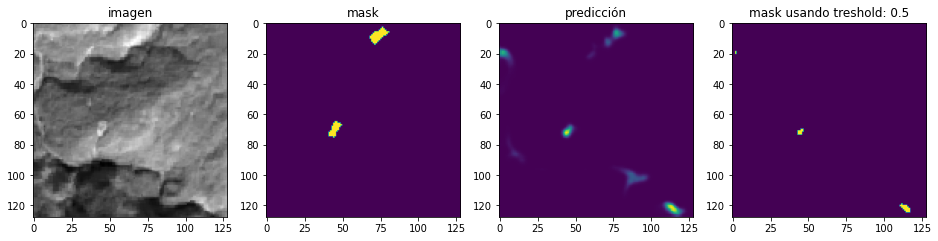

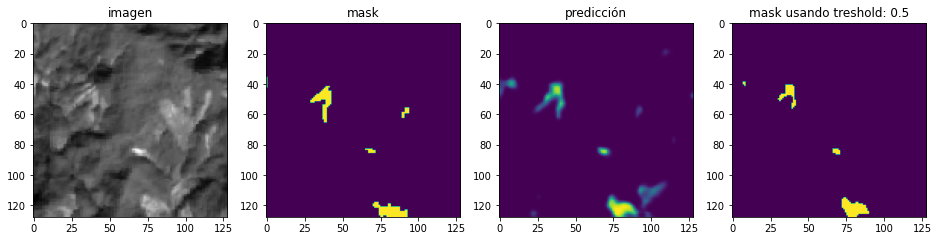

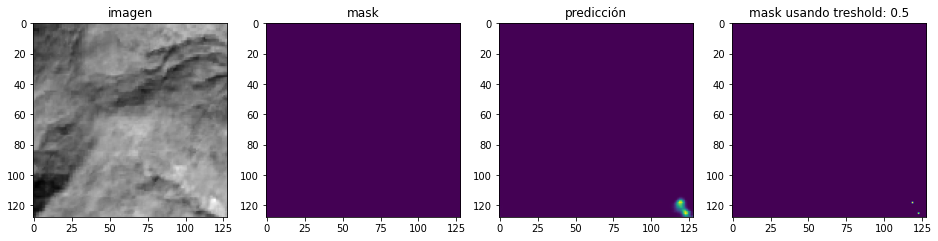

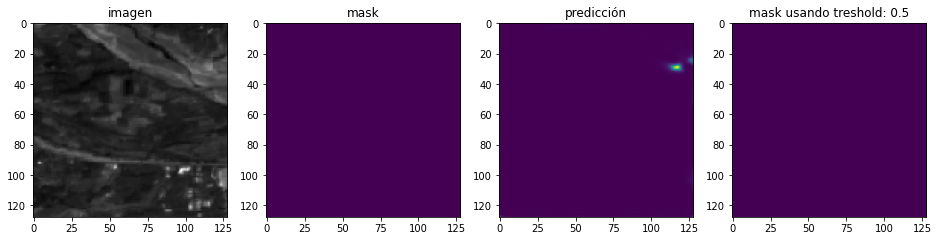

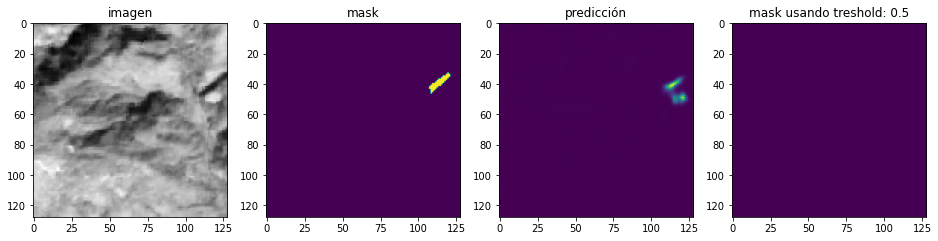

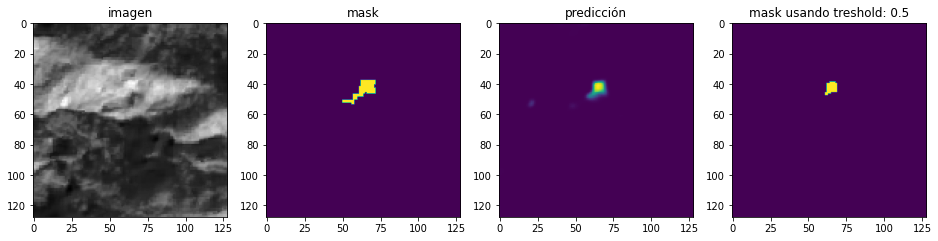

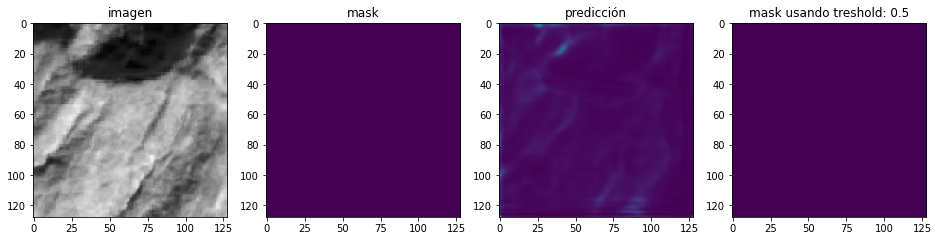

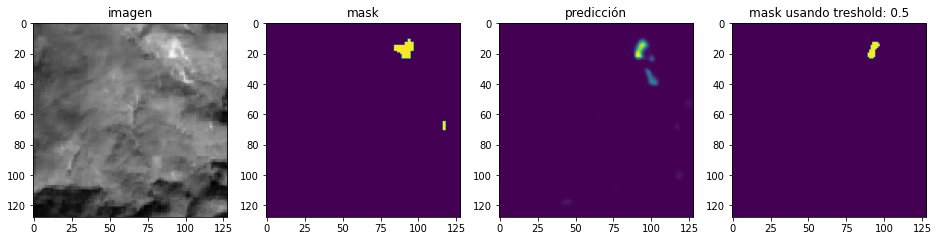

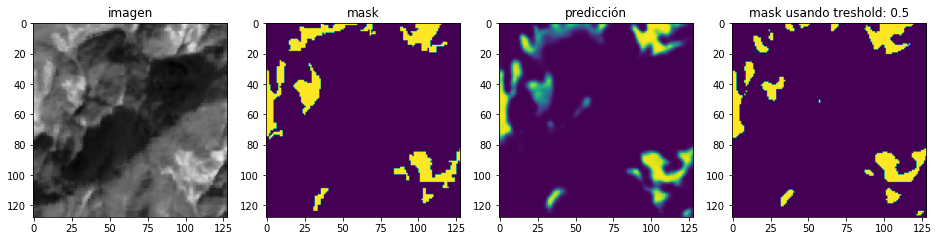

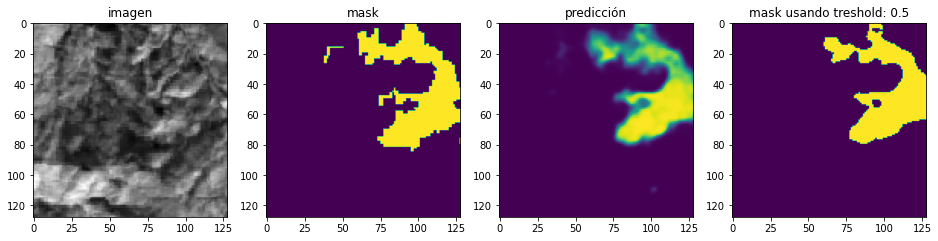

In [47]:
images_to_see = test_imgs[:10]
masks_to_see = test_masks[:10]


for image,mask in zip(images_to_see,masks_to_see):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
    with h5py.File(image, "r") as f_img , h5py.File(mask, "r") as f_mask:
        a_group_key = list(f_img.keys())[0]
        img = np.array(f_img[a_group_key])
        prediction = np.array(model_landslide(img.reshape(1,128,128,14)))
        prediction_hard = prediction.copy()
        prediction_hard[prediction_hard > 0.5] = 1
        prediction_hard[prediction_hard <0.5] = 0

        
        gray_img = img.mean(axis=-1)
        
        b_group_key = list(f_mask.keys())[0]
        mask = np.array(f_mask[b_group_key])
        
        
        
        axs[0].imshow(gray_img,cmap='gray')
        axs[0].set_title("imagen")
        axs[1].imshow(mask)
        axs[1].set_title("mask")
        axs[2].imshow(prediction.squeeze())
        axs[2].set_title("predicción")
        axs[3].imshow(prediction_hard.squeeze())
        axs[3].set_title("mask usando treshold: 0.5")
        plt.show()

        

In [48]:
images_to_see = test_imgs
masks_to_see = test_masks
n_valid_sample_all = 0
TP_all = np.zeros((2, 1))
FP_all = np.zeros((2, 1))
TN_all = np.zeros((2, 1))
FN_all = np.zeros((2, 1))
F1 = np.zeros((2, 1))
epsilon = 1e-14
name_classes = ['Non-Landslide','Landslide']

# Aquí sería mejor implementar un generator para predecir, pero ya lo hice así.

for image,mask in zip(images_to_see,masks_to_see):
    with h5py.File(image, "r") as f_img , h5py.File(mask, "r") as f_mask:
        a_group_key = list(f_img.keys())[0]
        img = np.array(f_img[a_group_key])
        prediction = np.array(model_landslide(img.reshape(1,128,128,14))) #aquí hago la predicción de cada imagen, deberíamos hacerlo con un generator en batches
        prediction_hard = prediction.copy()
        prediction_hard[prediction_hard > 0.5] = 1
        prediction_hard[prediction_hard <0.5] = 0

        
        gray_img = img.mean(axis=-1)
        
        b_group_key = list(f_mask.keys())[0]
        mask = np.array(f_mask[b_group_key])
        
        TP,FP,TN,FN,n_valid_sample = eval_image(prediction_hard.reshape(-1),mask.reshape(-1),2)
        
        TP_all += TP
        FP_all += FP
        TN_all += TN
        FN_all += FN
        n_valid_sample_all += n_valid_sample

OA = np.sum(TP_all)*1.0 / n_valid_sample_all
for i in range(2):
    P = TP_all[i]*1.0 / (TP_all[i] + FP_all[i] + epsilon)
    R = TP_all[i]*1.0 / (TP_all[i] + FN_all[i] + epsilon)
    F1[i] = 2.0*P*R / (P + R + epsilon)
    if i==1:
        print('===>' + name_classes[i] + ' Precision: %.2f'%(P * 100))
        print('===>' + name_classes[i] + ' Recall: %.2f'%(R * 100))                
        print('===>' + name_classes[i] + ' F1: %.2f'%(F1[i] * 100))

mF1 = np.mean(F1)            
print('===> mean F1: %.2f OA: %.2f'%(mF1*100,OA*100))

===>Landslide Precision: 77.49
===>Landslide Recall: 68.61
===>Landslide F1: 72.78
===> mean F1: 86.08 OA: 98.79


In [49]:
%%capture
# para generar las predicciones, quedará un archivo base.zip en el directorio output/kaggle/working/
snapshot_dir = ''
imgs_predict = sorted(glob.glob(path+"img/img/*.h5"))
for image in imgs_predict:
    with h5py.File(image, "r") as f_img:
        name = image.split('/')[-1]
        name = 'mask' + name[5:]
        a_group_key = list(f_img.keys())[0]
        img = np.array(f_img[a_group_key])
        prediction = np.array(model_landslide(img.reshape(1,128,128,14)))
        prediction_hard = prediction.copy()
        prediction_hard[prediction_hard > 0.5] = 1
        prediction_hard[prediction_hard <0.5] = 0
        pred = prediction_hard.squeeze().astype('uint8')         
        with h5py.File(snapshot_dir+name,'w') as hf:
            hf.create_dataset('mask', data=pred)
            
command = "zip base.zip ./*.h5"
os.system(command)

  adding: mask_1.h5 (deflated 98%)
  adding: mask_10.h5 (deflated 97%)
  adding: mask_100.h5 (deflated 99%)
  adding: mask_101.h5 (deflated 99%)
  adding: mask_102.h5 (deflated 99%)
  adding: mask_103.h5 (deflated 99%)
  adding: mask_104.h5 (deflated 99%)
  adding: mask_105.h5 (deflated 98%)
  adding: mask_106.h5 (deflated 99%)
  adding: mask_107.h5 (deflated 98%)
  adding: mask_108.h5 (deflated 99%)
  adding: mask_109.h5 (deflated 98%)
  adding: mask_11.h5 (deflated 97%)
  adding: mask_110.h5 (deflated 98%)
  adding: mask_111.h5 (deflated 99%)
  adding: mask_112.h5 (deflated 99%)
  adding: mask_113.h5 (deflated 98%)
  adding: mask_114.h5 (deflated 98%)
  adding: mask_115.h5 (deflated 99%)
  adding: mask_116.h5 (deflated 98%)
  adding: mask_117.h5 (deflated 99%)
  adding: mask_118.h5 (deflated 99%)
  adding: mask_119.h5 (deflated 98%)
  adding: mask_12.h5 (deflated 99%)
  adding: mask_120.h5 (deflated 99%)
  adding: mask_121.h5 (deflated 99%)
  adding: mask_122.h5 (deflated 99%)
  addi

#### Si alguien desea participar en la competencia puede ocupar este código como base.